# Cox-Munk PDF & CDF Test

In [273]:
import numpy as np
from numpy.polynomial.legendre import leggauss

In [274]:
eps = 0.01745154894888401

def cos(x):
    if x < 0:
        x = x + 2 * np.pi
    cs = np.cos(x)
    if np.abs(cs) < eps:
        if x > np.pi / 2 and x < (3 * np.pi) / 2:
            cs = np.clip(cs, -1, -eps)
        else:
            cs = np.clip(cs, eps, 1)
    return cs

def sin(x): 
    if x < 0:
        x = x + 2 * np.pi
    ss = np.sin(x)
    if np.abs(ss) < eps:
        if x > np.pi:
            ss = np.clip(ss, -1, -eps)
        else:
            ss = np.clip(ss, eps, 1)
    return ss

def cox_munk(theta_i, theta_o, phi_d, phi_w, u):
    c_40 = 0.40
    c_22 = 0.12
    c_04 = 0.23
    c_21 = 0.01 - 0.0086 * u
    c_03 = 0.04 - 0.033 * u

    sc_sqr = 0.003 + 0.00192 * u
    su_sqr = 0.00316 * u

    denom = cos(theta_i) + cos(theta_o)
    z_x = (-sin(theta_o) * sin(phi_d)) / denom
    z_y = (sin(theta_i) + sin(theta_o) * cos(phi_d)) / denom

    z_x_prime = z_x * cos(phi_w) + z_y * sin(phi_w)
    z_y_prime = -z_x * sin(phi_w) + z_y * cos(phi_w)

    ksi = z_x_prime / np.sqrt(sc_sqr)
    eta = z_y_prime / np.sqrt(su_sqr)

    coeff = 1.0 - (c_21 / 2.0) * (ksi**2 - 1.0) * eta
    coeff = coeff - (c_03 / 6.0) * (eta**3 - 3.0 * eta)
    coeff = coeff + (c_40 / 24.0) * (ksi**4 - 6.0 * ksi**2 + 3.0)
    coeff = coeff + (c_22 / 4.0) * (ksi**2 - 1.0) * (eta**2 - 1.0)
    coeff = coeff + (c_04 / 24.0) * (eta**4 - 6.0 * eta**2 + 3.0)
    coeff = coeff * np.exp(-0.5 * (ksi**2 + eta**2))
    factor = 1.0 / (2.0 * np.pi * np.sqrt(sc_sqr) * np.sqrt(su_sqr))
    res = factor * coeff / 4.32

    return  res

def cox_munk_pp(theta_i, theta_o, phi_d, phi_w, wind_speed):
    c_40 = 0.40
    c_22 = 0.12
    c_04 = 0.23

    sigma_c = 0.003 + 0.00192 * wind_speed
    sigma_u = 0.00316 * wind_speed

    c_21 = 0.01 - 0.0086 * wind_speed
    c_03 = 0.04 - 0.033 * wind_speed

    denom = cos(theta_i) + cos(theta_o)
    z_x = (-sin(theta_o) * sin(phi_d)) / denom
    z_y = (sin(theta_i) + sin(theta_o) * cos(phi_d)) / denom

    xe = (cos(phi_w) * z_x + sin(phi_w) * z_y) / np.sqrt(sigma_c)
    xn = (-sin(phi_w) * z_x + cos(phi_w) * z_y) / np.sqrt(sigma_u)

    xe2 = xe * xe
    xn2 = xn * xn
    
    coef = 1.0 - (c_21 / 2.0) * (xe2 - 1.0) * xn - (c_03 / 6.0) * (xn2 - 3.0) * xn
    coef = coef + (c_40 / 24.0) * (xe2 * xe2 - 6.0 * xe2 + 3.0)
    coef = coef + (c_04 / 24.0) * (xn2 * xn2 - 6.0 * xn2 + 3.0)
    coef = coef + (c_22 / 4.0) * (xe2 - 1.0) * (xn2 - 1.0)
    
    prob = coef / 2.0 / np.pi / np.sqrt(sigma_u) / np.sqrt(sigma_c) * np.exp(-(xe2 + xn2) / 2.0)
    return prob / 4.32


In [275]:
wind_azimuth = 0
incoming_zenith = 45
incoming_azimuth = 0
chi = incoming_azimuth - wind_azimuth
zeniths = np.linspace(0, np.deg2rad(89), 90)
azimuths = np.linspace(0, 2 * np.pi, 360)
data = np.zeros((len(zeniths), len(azimuths)))

wind_speed = 1
theta_i = np.deg2rad(incoming_zenith)
phi_w = np.deg2rad(chi)
for i, theta_o in enumerate(zeniths):
    for j, phi_o in enumerate(azimuths):
        phi_d = np.deg2rad(incoming_azimuth) - phi_o
        data[i, j] = cox_munk_pp(theta_i, theta_o, phi_d, phi_w, wind_speed)

# Check if data has NaNs
if np.isnan(data).any():
    print("Data contains NaNs")

([<matplotlib.axis.YTick at 0x1871baaf0>,
 [Text(0, 0.0, '0'),
  Text(0, 0.5235987755982988, '$\\pi/6$'),
  Text(0, 1.0471975511965976, '$\\pi/3$'),
  Text(0, 1.5707963267948966, '$\\pi/2$')])

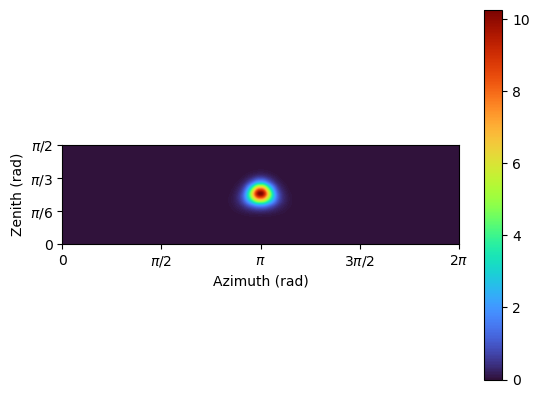

In [276]:
# Plot using Turbo colormap (on a rectangular grid)
import matplotlib.pyplot as plt
plt.imshow(data, cmap='turbo', origin='lower', extent=[0, 2 * np.pi, 0, np.pi / 2])
plt.colorbar()

# Set axis titles
plt.xlabel('Azimuth (rad)')
plt.ylabel('Zenith (rad)')

# Set axis ticks
plt.xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.yticks([0, np.pi / 6, np.pi / 3, np.pi / 2], ['0', '$\pi/6$', '$\pi/3$', '$\pi/2$'])

In [277]:
# Quadrature
def test_quadrature():
    solar_pts = 90
    solar_zeniths = np.linspace(0, np.deg2rad(89), solar_pts)
    solar_weight = 1.0 / solar_pts
    solar_estimate = 0.0

    idx = 0
    max_idx = len(solar_zeniths)
    for solar_zenith in solar_zeniths:
        theta_i = solar_zenith
        azimuth_pts, azimuth_weights = leggauss(360)
        zenith_pts, zenith_weights = leggauss(90)

        transformed_azimuths = np.pi * (azimuth_pts + 1)
        transformed_zeniths = (np.pi / 4) * (zenith_pts + 1)

        x, y = np.meshgrid(transformed_azimuths, transformed_zeniths, indexing='ij')
        points = np.vstack([x.ravel(), y.ravel()]).T

        w_x, w_y = np.meshgrid(azimuth_weights, zenith_weights, indexing='ij')
        weights = (w_x * w_y).ravel() * ((np.pi**2) / 4)

        # The function to integrate
        def f(theta_o, phi_o):
            phi_d = np.deg2rad(incoming_azimuth) - phi_o
            return cox_munk_pp(theta_i, theta_o, phi_d, phi_w, wind_speed)
            
        integrand_values = np.array([f(x, y) for x, y in points])
        intgrand = np.sum(integrand_values * weights)
        solar_estimate = solar_estimate + intgrand

        idx = idx + 1
        print(f'Progress: {idx}/{max_idx}')

    print("Solar estimate: ", solar_estimate * solar_weight)